In [1]:
import os
from os.path import join
import torch
from torchvision.datasets import ImageNet
from torchvision import transforms
from torchvision.transforms import functional as F
import torch.nn.functional as batch
import torchvision
import torch.nn as nn

from matplotlib import pyplot as plt
import numpy as np
from tqdm import tqdm
from random import random
import torch.multiprocessing as mp
from torch.utils.data import random_split, DataLoader, Subset



In [2]:

# Define the image limit
BATCH_SIZE = 64
TRAIN_SIZE = 150 * BATCH_SIZE
TEST_SIZE = 10 * BATCH_SIZE
LOSS_EVERY = 1
EPOCHS = 1
SPLIT = 'train'
WEIGHT_DECAY=1e-2
LEARNING_RATE = .00005

device = os.environ["DEVICE"]
utils = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_convnets_processing_utils', )

DATA_DIR = os.environ['DATA_PATH']
CACHE_DIR = join(DATA_DIR, 'imagenet_inversion')
RESNET_SIZE = 224

class CachedImageNet(ImageNet):

    def __init__(self, root, split, version='0.1'):
        TRANSFORM = transforms.Compose([
            transforms.CenterCrop(224),
            transforms.ToTensor(),
        ])
        super().__init__(root=root, split=split, transform=TRANSFORM)
        self.cache_dir = os.path.join(CACHE_DIR, version, split)

        # Create cache directory if it doesn't exist
        os.makedirs(self.cache_dir, exist_ok=True)
        self.resnet50 = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_resnet50', pretrained=True)
        self.resnet50.eval().to(device)
        self.resnet_layer = self.resnet50.layers[2][0].downsample[0]


    def _get_cache_path(self, index):
        """Get the path for the cached feature."""
        return os.path.join(self.cache_dir, f'feature_{index}.pt')

    def __getitem__(self, index):
        # Load the image and label
        img, object_class = super().__getitem__(index)

        cache_path = self._get_cache_path(index)
        features = None
        if not os.path.exists(cache_path) or random() < .01:
            # Image transformations
            IMGNET_NORM = transforms.Compose([
                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
            ])
            imgnet_input = F.rgb_to_grayscale(IMGNET_NORM(img), num_output_channels=3).to(device).unsqueeze(0)

            def assign_features(module, input, output):
                nonlocal features
                features = output
            hook = self.resnet_layer.register_forward_hook(assign_features)
            
            with torch.no_grad():
                self.resnet50(imgnet_input)
            hook.remove()
            assert features is not None
            features = features.squeeze(0)
            if os.path.exists(cache_path):
                saved_features = torch.load(cache_path).to(device)
                assert torch.equal(features,saved_features)

            self.save_atomic(features, cache_path)
        else:
            features = torch.load(cache_path).to(device)

        target = F.rgb_to_grayscale(img, num_output_channels=1)
        return features, target
    def save_atomic(self, value, name):
        tmp_name = name + '.tmp' + str(random())
        torch.save(value, tmp_name)
        os.replace(tmp_name, name)
# Example feature extractor: compute mean/std per channel



# Set the start method to 'spawn'
mp.set_start_method('spawn', force=True)
# Initialize CachedImageNet
train_dataset = CachedImageNet(
    root=join(DATA_DIR, 'imagenet'),
    split=SPLIT,
    version='0.9'
)


assert(len(train_dataset) >= TRAIN_SIZE + TEST_SIZE)

# Define the split sizes

# Split the dataset within the limit
train_subset_indices = list(range(TRAIN_SIZE))  # Indices for the training subset
test_subset_indices = list(range(TRAIN_SIZE, TRAIN_SIZE + TEST_SIZE))  # Indices for the test subset

# Create the subsets
train_subset = Subset(train_dataset, train_subset_indices)
test_subset = Subset(train_dataset, test_subset_indices)

# Define the batch size

# Create DataLoaders for train and test
train_loader = DataLoader(
    dataset=train_subset,
    batch_size=BATCH_SIZE,
    shuffle=True,  # Shuffle can be enabled based on your training needs
    num_workers=0
)

test_loader = DataLoader(
    dataset=test_subset,
    batch_size=BATCH_SIZE,
    shuffle=False,  # No need to shuffle test data
    num_workers=0
)

print(f"Train loader contains {len(train_loader)} batches.")
print(f"Test loader contains {len(test_loader)} batches.")


Using cache found in /home/vanousek/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub
/home/vanousek/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub/PyTorch/Classification/ConvNets/image_classification/models/common.py:13: UserWarning: pytorch_quantization module not found, quantization will not be available
  warnings.warn(
/home/vanousek/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub/PyTorch/Classification/ConvNets/image_classification/models/efficientnet.py:17: UserWarning: pytorch_quantization module not found, quantization will not be available
  warnings.warn(


Using cache found in /home/vanousek/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub


Train loader contains 150 batches.
Test loader contains 10 batches.


torch.Size([64, 1, 224, 224])


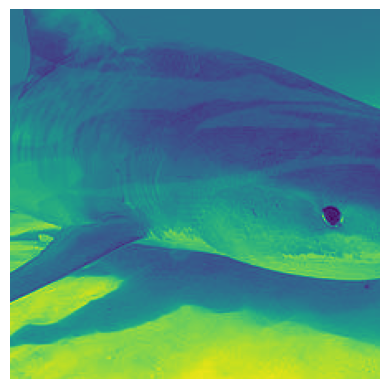

In [3]:
# Get a batch from the DataLoader
def show_image(img_tensor):
    img = img_tensor.cpu().numpy().transpose((1, 2, 0))  # Convert to HWC
    plt.imshow(img)
    plt.axis('off')
    plt.show()


data_iter = iter(train_loader)  # Replace `train_loader` with your DataLoader
features, targets = next(data_iter)
print(targets.shape)
show_image(targets[0])  # Show the first image in the batch

In [4]:
class UpsampleModel(nn.Module):
    def __init__(self):
        super(UpsampleModel, self).__init__()
        self.model = nn.Sequential(
            nn.ConvTranspose2d(
                in_channels=1024, out_channels=768,
                kernel_size=4, stride=2, padding=1
            ),
            nn.BatchNorm2d(768),
            nn.LeakyReLU(0.1),
            nn.ConvTranspose2d(
                in_channels=768, out_channels=512,
                kernel_size=4, stride=2, padding=1
            ),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.1),
            nn.ConvTranspose2d(
                in_channels=512, out_channels=384,
                kernel_size=4, stride=2, padding=1
            ),
            nn.BatchNorm2d(384),
            nn.LeakyReLU(0.1),
            nn.ConvTranspose2d(
                in_channels=384, out_channels=256,
                kernel_size=4, stride=2, padding=1
            ),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.1),
            nn.ConvTranspose2d(256, 128, kernel_size=5, padding=2),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.1),
            nn.ConvTranspose2d(128, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.1),
            nn.ConvTranspose2d(64, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.1),
            nn.ConvTranspose2d(32, 16, kernel_size=1, padding=0),
            nn.BatchNorm2d(16),
            nn.LeakyReLU(0.1),
            nn.ConvTranspose2d(16, 1, kernel_size=1, padding=0)
        )

    def forward(self, x):
        return self.model(x)



# Example usage:
model = UpsampleModel()


input_tensor = torch.randn(1, 1024, 14, 14)  # Batch size = 1
output_tensor = model(input_tensor)
assert output_tensor.shape == torch.Size([1,1,224,224])

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
params = count_parameters(model)
print("Total parametrs: ", params)
print("Params in samples : ", params / (224*224))

Total parametrs:  24511329
Params in samples :  488.5070352359694


In [5]:
criterion = torch.nn.BCEWithLogitsLoss(reduction='mean')
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

T_max = len(train_loader) * EPOCHS  # Total number of batches across all epochs

scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max)

In [6]:
import torch


# Training loop
model.train()
model.to(device)
running_loss = 0.0
losses = []
for epoch in range(EPOCHS):
    for i, (features, target) in enumerate(train_loader):
        features = features.to(device)  # Move to device
        target = target.to(device)

        # Forward pass
        outputs = model(features)
        loss = criterion(outputs, target)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Step the scheduler after each batch
        scheduler.step()

        # Log the running loss
        running_loss += loss.item()
        if i % LOSS_EVERY == LOSS_EVERY - 1:
            avg_loss = running_loss / LOSS_EVERY
            print(f"Epoch {epoch+1}, Batch {i+1}, LR: {scheduler.get_last_lr()[0]:.6f}, Loss: {avg_loss:.4f}")
            losses.append(avg_loss)
            running_loss = 0.0


Epoch 1, Batch 1, LR: 0.000050, Loss: 0.9870


Epoch 1, Batch 2, LR: 0.000050, Loss: 0.9053


Epoch 1, Batch 3, LR: 0.000050, Loss: 0.8450


Epoch 1, Batch 4, LR: 0.000050, Loss: 0.7641


Epoch 1, Batch 5, LR: 0.000050, Loss: 0.7623


Epoch 1, Batch 6, LR: 0.000050, Loss: 0.7169


Epoch 1, Batch 7, LR: 0.000050, Loss: 0.6913


Epoch 1, Batch 8, LR: 0.000050, Loss: 0.6790


Epoch 1, Batch 9, LR: 0.000050, Loss: 0.6793


Epoch 1, Batch 10, LR: 0.000049, Loss: 0.6660


Epoch 1, Batch 11, LR: 0.000049, Loss: 0.6594


Epoch 1, Batch 12, LR: 0.000049, Loss: 0.6362


Epoch 1, Batch 13, LR: 0.000049, Loss: 0.6215


Epoch 1, Batch 14, LR: 0.000049, Loss: 0.6650


Epoch 1, Batch 15, LR: 0.000049, Loss: 0.6372


Epoch 1, Batch 16, LR: 0.000049, Loss: 0.6584


Epoch 1, Batch 17, LR: 0.000048, Loss: 0.5900


Epoch 1, Batch 18, LR: 0.000048, Loss: 0.5969


Epoch 1, Batch 19, LR: 0.000048, Loss: 0.6478


Epoch 1, Batch 20, LR: 0.000048, Loss: 0.5989


Epoch 1, Batch 21, LR: 0.000048, Loss: 0.6467


Epoch 1, Batch 22, LR: 0.000047, Loss: 0.6430


Epoch 1, Batch 23, LR: 0.000047, Loss: 0.5894


Epoch 1, Batch 24, LR: 0.000047, Loss: 0.5716


Epoch 1, Batch 25, LR: 0.000047, Loss: 0.6259


Epoch 1, Batch 26, LR: 0.000046, Loss: 0.5890


Epoch 1, Batch 27, LR: 0.000046, Loss: 0.5904


Epoch 1, Batch 28, LR: 0.000046, Loss: 0.5999


Epoch 1, Batch 29, LR: 0.000046, Loss: 0.6262


Epoch 1, Batch 30, LR: 0.000045, Loss: 0.6356


Epoch 1, Batch 31, LR: 0.000045, Loss: 0.6016


Epoch 1, Batch 32, LR: 0.000045, Loss: 0.6009


Epoch 1, Batch 33, LR: 0.000044, Loss: 0.5932


Epoch 1, Batch 34, LR: 0.000044, Loss: 0.5942


Epoch 1, Batch 35, LR: 0.000044, Loss: 0.5922


Epoch 1, Batch 36, LR: 0.000043, Loss: 0.5963


Epoch 1, Batch 37, LR: 0.000043, Loss: 0.6145


Epoch 1, Batch 38, LR: 0.000042, Loss: 0.5849


Epoch 1, Batch 39, LR: 0.000042, Loss: 0.6042


Epoch 1, Batch 40, LR: 0.000042, Loss: 0.5860


Epoch 1, Batch 41, LR: 0.000041, Loss: 0.5842


Epoch 1, Batch 42, LR: 0.000041, Loss: 0.5983


Epoch 1, Batch 43, LR: 0.000041, Loss: 0.5951


Epoch 1, Batch 44, LR: 0.000040, Loss: 0.6010


Epoch 1, Batch 45, LR: 0.000040, Loss: 0.6106


Epoch 1, Batch 46, LR: 0.000039, Loss: 0.6101


Epoch 1, Batch 47, LR: 0.000039, Loss: 0.6090


Epoch 1, Batch 48, LR: 0.000038, Loss: 0.5859


Epoch 1, Batch 49, LR: 0.000038, Loss: 0.5942


Epoch 1, Batch 50, LR: 0.000037, Loss: 0.5762


Epoch 1, Batch 51, LR: 0.000037, Loss: 0.5758


Epoch 1, Batch 52, LR: 0.000037, Loss: 0.5903


Epoch 1, Batch 53, LR: 0.000036, Loss: 0.5810


Epoch 1, Batch 54, LR: 0.000036, Loss: 0.5930


Epoch 1, Batch 55, LR: 0.000035, Loss: 0.5685


Epoch 1, Batch 56, LR: 0.000035, Loss: 0.5828


Epoch 1, Batch 57, LR: 0.000034, Loss: 0.5789


Epoch 1, Batch 58, LR: 0.000034, Loss: 0.5885


Epoch 1, Batch 59, LR: 0.000033, Loss: 0.5764


Epoch 1, Batch 60, LR: 0.000033, Loss: 0.5868


Epoch 1, Batch 61, LR: 0.000032, Loss: 0.5966


Epoch 1, Batch 62, LR: 0.000032, Loss: 0.5682


Epoch 1, Batch 63, LR: 0.000031, Loss: 0.5646


Epoch 1, Batch 64, LR: 0.000031, Loss: 0.5663


Epoch 1, Batch 65, LR: 0.000030, Loss: 0.5787


Epoch 1, Batch 66, LR: 0.000030, Loss: 0.5905


Epoch 1, Batch 67, LR: 0.000029, Loss: 0.5916


Epoch 1, Batch 68, LR: 0.000029, Loss: 0.5988


Epoch 1, Batch 69, LR: 0.000028, Loss: 0.5748


Epoch 1, Batch 70, LR: 0.000028, Loss: 0.6071


Epoch 1, Batch 71, LR: 0.000027, Loss: 0.5983


Epoch 1, Batch 72, LR: 0.000027, Loss: 0.5706


Epoch 1, Batch 73, LR: 0.000026, Loss: 0.5958


Epoch 1, Batch 74, LR: 0.000026, Loss: 0.6100


Epoch 1, Batch 75, LR: 0.000025, Loss: 0.5839


Epoch 1, Batch 76, LR: 0.000024, Loss: 0.6017


Epoch 1, Batch 77, LR: 0.000024, Loss: 0.6042


Epoch 1, Batch 78, LR: 0.000023, Loss: 0.6004


Epoch 1, Batch 79, LR: 0.000023, Loss: 0.5728


Epoch 1, Batch 80, LR: 0.000022, Loss: 0.5862


Epoch 1, Batch 81, LR: 0.000022, Loss: 0.5926


Epoch 1, Batch 82, LR: 0.000021, Loss: 0.5686


Epoch 1, Batch 83, LR: 0.000021, Loss: 0.5937


Epoch 1, Batch 84, LR: 0.000020, Loss: 0.5804


Epoch 1, Batch 85, LR: 0.000020, Loss: 0.5833


Epoch 1, Batch 86, LR: 0.000019, Loss: 0.5867


Epoch 1, Batch 87, LR: 0.000019, Loss: 0.6062


Epoch 1, Batch 88, LR: 0.000018, Loss: 0.5747


Epoch 1, Batch 89, LR: 0.000018, Loss: 0.5767


Epoch 1, Batch 90, LR: 0.000017, Loss: 0.6070


Epoch 1, Batch 91, LR: 0.000017, Loss: 0.5722


Epoch 1, Batch 92, LR: 0.000016, Loss: 0.5905


Epoch 1, Batch 93, LR: 0.000016, Loss: 0.5811


Epoch 1, Batch 94, LR: 0.000015, Loss: 0.5817


Epoch 1, Batch 95, LR: 0.000015, Loss: 0.5868


Epoch 1, Batch 96, LR: 0.000014, Loss: 0.5693


Epoch 1, Batch 97, LR: 0.000014, Loss: 0.5853


Epoch 1, Batch 98, LR: 0.000013, Loss: 0.5785


Epoch 1, Batch 99, LR: 0.000013, Loss: 0.5854


Epoch 1, Batch 100, LR: 0.000012, Loss: 0.6029


Epoch 1, Batch 101, LR: 0.000012, Loss: 0.5772


Epoch 1, Batch 102, LR: 0.000012, Loss: 0.5589


Epoch 1, Batch 103, LR: 0.000011, Loss: 0.5902


Epoch 1, Batch 104, LR: 0.000011, Loss: 0.5842


Epoch 1, Batch 105, LR: 0.000010, Loss: 0.5679


Epoch 1, Batch 106, LR: 0.000010, Loss: 0.5764


Epoch 1, Batch 107, LR: 0.000009, Loss: 0.5608


Epoch 1, Batch 108, LR: 0.000009, Loss: 0.5894


Epoch 1, Batch 109, LR: 0.000009, Loss: 0.5858


Epoch 1, Batch 110, LR: 0.000008, Loss: 0.5721


Epoch 1, Batch 111, LR: 0.000008, Loss: 0.5917


Epoch 1, Batch 112, LR: 0.000008, Loss: 0.6059


Epoch 1, Batch 113, LR: 0.000007, Loss: 0.5858


Epoch 1, Batch 114, LR: 0.000007, Loss: 0.5893


Epoch 1, Batch 115, LR: 0.000006, Loss: 0.5794


Epoch 1, Batch 116, LR: 0.000006, Loss: 0.5911


Epoch 1, Batch 117, LR: 0.000006, Loss: 0.5703


Epoch 1, Batch 118, LR: 0.000005, Loss: 0.5791


Epoch 1, Batch 119, LR: 0.000005, Loss: 0.5816


Epoch 1, Batch 120, LR: 0.000005, Loss: 0.5669


Epoch 1, Batch 121, LR: 0.000004, Loss: 0.5758


Epoch 1, Batch 122, LR: 0.000004, Loss: 0.5904


Epoch 1, Batch 123, LR: 0.000004, Loss: 0.5844


Epoch 1, Batch 124, LR: 0.000004, Loss: 0.5889


Epoch 1, Batch 125, LR: 0.000003, Loss: 0.6022


Epoch 1, Batch 126, LR: 0.000003, Loss: 0.5571


Epoch 1, Batch 127, LR: 0.000003, Loss: 0.5961


Epoch 1, Batch 128, LR: 0.000003, Loss: 0.5784


Epoch 1, Batch 129, LR: 0.000002, Loss: 0.5841


Epoch 1, Batch 130, LR: 0.000002, Loss: 0.5916


Epoch 1, Batch 131, LR: 0.000002, Loss: 0.5873


Epoch 1, Batch 132, LR: 0.000002, Loss: 0.5880


Epoch 1, Batch 133, LR: 0.000002, Loss: 0.5833


Epoch 1, Batch 134, LR: 0.000001, Loss: 0.5885


Epoch 1, Batch 135, LR: 0.000001, Loss: 0.5876


Epoch 1, Batch 136, LR: 0.000001, Loss: 0.5794


Epoch 1, Batch 137, LR: 0.000001, Loss: 0.5777


Epoch 1, Batch 138, LR: 0.000001, Loss: 0.5910


Epoch 1, Batch 139, LR: 0.000001, Loss: 0.5804


Epoch 1, Batch 140, LR: 0.000001, Loss: 0.5847


Epoch 1, Batch 141, LR: 0.000000, Loss: 0.5705


Epoch 1, Batch 142, LR: 0.000000, Loss: 0.5570


Epoch 1, Batch 143, LR: 0.000000, Loss: 0.5789


Epoch 1, Batch 144, LR: 0.000000, Loss: 0.5816


Epoch 1, Batch 145, LR: 0.000000, Loss: 0.5783


Epoch 1, Batch 146, LR: 0.000000, Loss: 0.5751


Epoch 1, Batch 147, LR: 0.000000, Loss: 0.5608


Epoch 1, Batch 148, LR: 0.000000, Loss: 0.5615


Epoch 1, Batch 149, LR: 0.000000, Loss: 0.5755


Epoch 1, Batch 150, LR: 0.000000, Loss: 0.5739


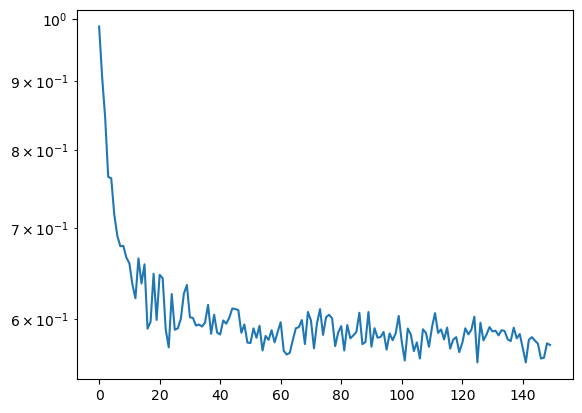

In [7]:
# Plot losses
plt.plot(losses)
plt.yscale('log')
# set maximum y to 

  0%|          | 0/10 [00:00<?, ?it/s]

 10%|█         | 1/10 [00:01<00:13,  1.49s/it]

 20%|██        | 2/10 [00:03<00:12,  1.61s/it]

 30%|███       | 3/10 [00:04<00:10,  1.53s/it]

 40%|████      | 4/10 [00:06<00:09,  1.62s/it]

 50%|█████     | 5/10 [00:07<00:07,  1.55s/it]

 60%|██████    | 6/10 [00:09<00:06,  1.57s/it]

 70%|███████   | 7/10 [00:11<00:04,  1.61s/it]

 80%|████████  | 8/10 [00:12<00:03,  1.64s/it]

 90%|█████████ | 9/10 [00:14<00:01,  1.60s/it]

100%|██████████| 10/10 [00:15<00:00,  1.59s/it]

100%|██████████| 10/10 [00:15<00:00,  1.59s/it]

Test Loss: 0.5649


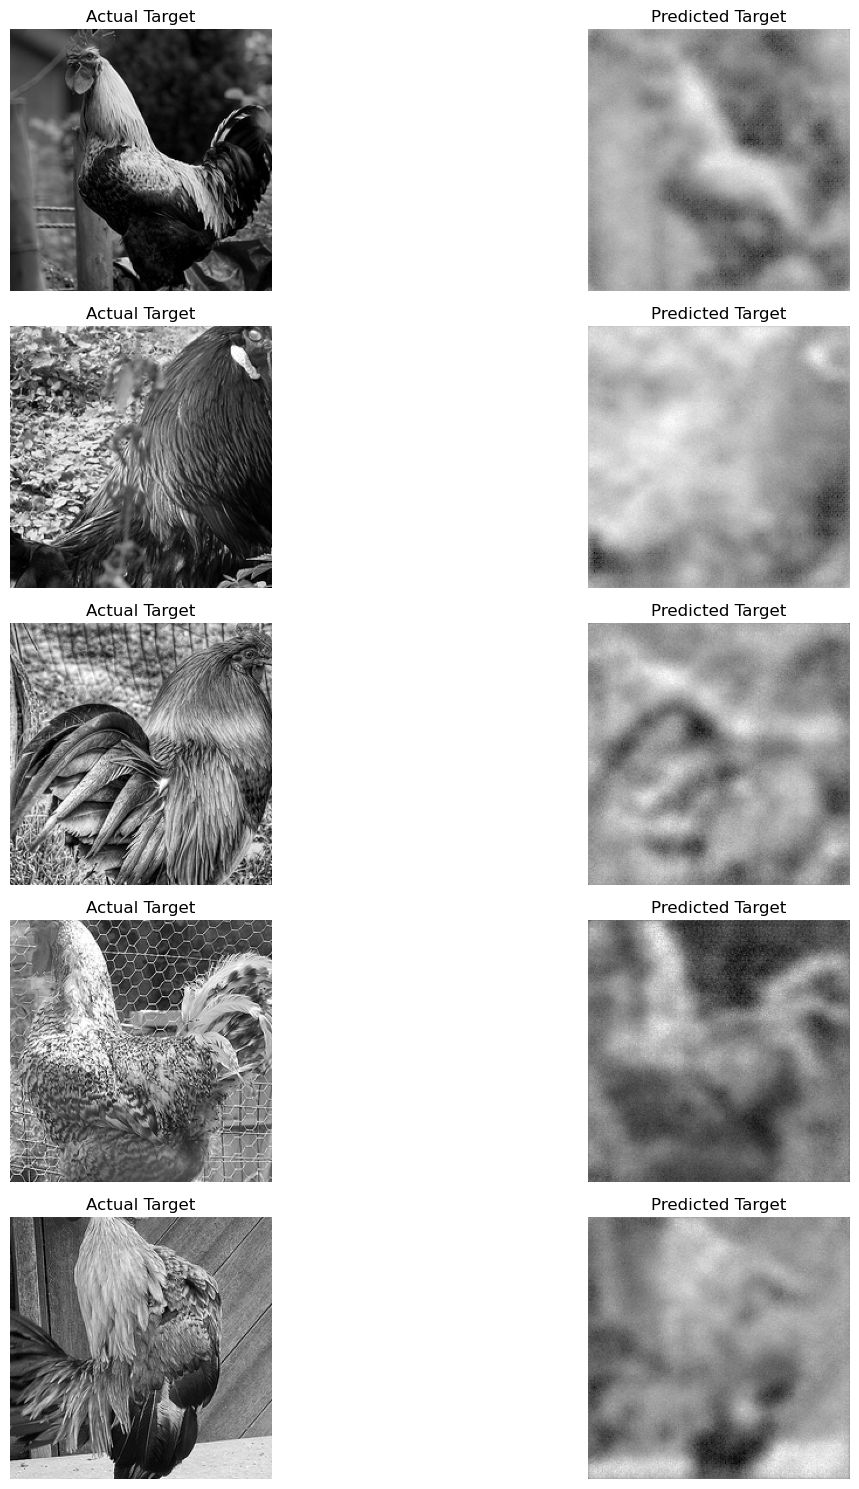

In [8]:
import matplotlib.pyplot as plt

def evaluate_partial_model(model, test_loader, device, max_batches=10_000):
    model.eval()
    test_loss = 0.0
    all_targets = []
    all_predictions = []

    num_batches = min(max_batches, len(test_loader)) 
    processed_batches = 0

    with torch.no_grad():
        for features, target in tqdm(test_loader):
            if processed_batches >= num_batches:
                break

            features = features.to(device)
            target = target.to(device)

            # Predict
            predictions = model(features)

            loss = criterion(predictions, target)
            test_loss += loss.item()

            # Store for plotting
            all_targets.append(target.cpu())
            all_predictions.append(predictions.cpu())

            processed_batches += 1

    test_loss /= processed_batches
    all_targets = torch.cat(all_targets, dim=0)
    all_predictions = torch.cat(all_predictions, dim=0)

    return test_loss, all_targets, all_predictions

# Evaluate on the first 10% of the test dataset
test_loss_partial, partial_targets, partial_predictions = evaluate_partial_model(model, test_loader, device)
print(f"Test Loss: {test_loss_partial:.4f}")

def plot_examples(targets, predictions, num_examples=5):
    plt.figure(figsize=(15, num_examples * 3))
    for i in range(num_examples):
        # Plot the actual target
        plt.subplot(num_examples, 2, 2 * i + 1)
        plt.imshow(targets[i].squeeze(), cmap='gray')  # Squeeze to remove extra dimension
        plt.title("Actual Target")
        plt.axis('off')

        # Plot the predicted target
        plt.subplot(num_examples, 2, 2 * i + 2)
        plt.imshow(predictions[i].squeeze(), cmap='gray')  # Squeeze to remove extra dimension
        plt.title("Predicted Target")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Plot Examples
num_examples = 5  # Number of examples to visualize
plot_examples(partial_targets[:num_examples].cpu().numpy(), partial_predictions[:num_examples].cpu().numpy())


In [9]:
print(partial_predictions.min(), partial_predictions.max())
print(partial_targets.min(), partial_targets.max())

tensor(-12.3675) tensor(4.4254)
tensor(0.) tensor(0.9999)


In [10]:
name_extra = os.environ['SLURM_JOB_ID'] if 'SLURM_JOB_ID' in os.environ else ''
torch.save(model, join(os.environ['MODELS_PATH'], "mlp" + name_extra + ".pt"))